In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os,sys
from collections import defaultdict
from ast import literal_eval

from from_excel_to_list import from_excel_to_list


In [49]:
positions_float_pd=pd.read_csv("../postprocessed-data/genetic_positions_float_pd_all_backgrounds.csv",converters={'Positions_float': literal_eval,'Ninsertions': literal_eval})
positions_float_pd.rename(columns={'Unnamed: 0':'Gene name', "Unnamed: 1": "background"},inplace=True)

discarded_genes_by_duplication=np.loadtxt("../postprocessed-data/discarded_genes_by_duplication.txt",dtype=str)

In [50]:
backgrounds= ['wt_merged','bem1-aid_a','bem1-aid_b','dbem1dbem3_a','dbem1dbem3_b',
'dnrp1_merged','dbem3_merged']

In [51]:
genes_out_by_neighborhood_pd=pd.read_excel("../postprocessed-data/genes_out_by_neighborhood.xlsx",index_col="Unnamed: 0")
from from_excel_to_list import from_excel_to_list
genes_out_float=defaultdict(dict)
for key in backgrounds:
   genes_out_float["sum upstream insertions"][key] =from_excel_to_list(genes_out_by_neighborhood_pd.loc[key,"sum upstream insertions"])
   genes_out_float["sum downstream insertions"][key] =from_excel_to_list(genes_out_by_neighborhood_pd.loc[key,"sum downstream insertions"])
   x=genes_out_by_neighborhood_pd.loc[key,"discarded_genes_neighborhood"]
   x=x.replace('[', '')
   x=x.replace(']', '')
   x=x.replace('list(', '')
   x=x.replace(')', '')
   x=x.replace("'", "")
   x=x.replace(" ", "")
   x=x.split(',')
   genes_out_float["discarded_genes_neighborhood"][key]=x

genes_out_float_pd=pd.DataFrame.from_dict(genes_out_float)

genes_out_float_pd.loc[:,"threshold coverage"]=genes_out_by_neighborhood_pd.loc[:,"threshold coverage"]

In [52]:
## Importing pergene files 

pergene_files=[]
data_dir="../postprocessed-data/"
#data_dir="../transposonmapper/data_files/"
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith("pergene_insertions.xlsx"):
            pergene_files.append(os.path.join(root, file))

list_data=[]
for i in pergene_files:
    list_data.append(pd.read_excel(i,engine='openpyxl',index_col="Unnamed: 0"))

keys=[]
for i in np.arange(0,len(pergene_files)):
    keys.append(pergene_files[i].split("/")[-1].split("_")[0]+"_"+pergene_files[i].split("/")[-1].split("_")[1])

list_data_pd=pd.concat(list_data,axis=0,keys=keys)




In [53]:
a=list_data_pd.loc["wt_merged"]
b=a[a.loc[:,"Gene name"]=="ADE2"]["Insertions"]
a["Insertions"].sum()-b

5805    251168
Name: Insertions, dtype: int64

### Discard the genes that contain one insertion with one read

In [54]:
## Discard insertions within the genes that have one read

## The idea is that those insertions are noisy insertions and dont give any information. 

# prototype

a_0_reads=from_excel_to_list(a["Reads per insertion location"][0])

## get locations of the reads that are equal to 1

## discard the insertion at that location and the reads at that location

## Import Benoit's data to validate our scores implementation and find out the differences with my results

In [55]:
benoit_wt_1=list_data_pd.loc["WT_1"]
benoit_wt_2=list_data_pd.loc["WT_2"]

benoit_wt_1.index=benoit_wt_1.loc[:,"Gene name"]
benoit_wt_2.index=benoit_wt_2.loc[:,"Gene name"]

## Strategy for scoring essentiality (Benoit method paper: https://elifesciences.org/articles/23570/figures#fig2s1)

- Compute the longest interval in the gene free of transposons insertions (L)
- Extract the number of insertions for that gene (N)
- Extract the gene length (l)
- Compute the score as:
    score= L*N/(l ^(1.5))
    score == 0 if 
    - N<20 OR
    - L>90 of l OR
    - L<10 of l OR
    - L<300bp

    
  

In [56]:
from functions_scores_essentiality import get_genes_names_for_essentiality
from functions_scores_essentiality import get_essentiality_score_per_gene_per_background
from functions_scores_essentiality import exclude_genes_with_one_or_two_reads
from functions_scores_essentiality import get_no_duplicates_gene_names

In [57]:
scores_benoit=[]

for key,index in zip(["WT_1","WT_2"],[benoit_wt_1.index,benoit_wt_2.index]) :
    scores=get_essentiality_score_per_gene_per_background(index,key,list_data_pd)
    tmp=pd.DataFrame.from_dict(scores)
    scores_benoit.append(tmp)

scores_benoit_pd=pd.concat(scores_benoit,axis=0,keys=["WT_1","WT_2"])

In [58]:
## Loop over all the backgrounds
scores_all=[]
# discard genes only if they duplicated (considering the WT background)
useful_genes=get_no_duplicates_gene_names(list_data_pd,discarded_genes_by_duplication)

for key in backgrounds:
    
    # discard genes that are duplicated and the neighborhoud has low coverage
    #useful_genes=get_genes_names_for_essentiality(list_data_pd,discarded_genes_by_duplication,genes_out_float_pd,key)
    
   
    scores=get_essentiality_score_per_gene_per_background(useful_genes,key,list_data_pd)
    tmp=pd.DataFrame.from_dict(scores)
    scores_all.append(tmp)



In [59]:
#### Scores  ##############

## The highest the score is the highest the likelihood to be essential because it will 
# contain clear domains void of transposons . If this score is equal zero we dont have information about
# the essentiality of the gene. 

scores_all_pd=pd.concat(scores_all,axis=0,keys=backgrounds) 

scores_all_pd.sort_values(by="value",ascending=False,inplace=False)
scores_all_pd

value
wt_merged    AAC1   0.395932
             AAC3   0.329796
             AAD10  0.000000
             AAD14  0.300799
             AAD15  0.000000
...                      ...
dbem3_merged ZRT2   0.000000
             ZRT3   0.000000
             ZTA1   0.000000
             ZUO1   0.467329
             ZWF1   0.000000

[45433 rows x 1 columns]

In [60]:
#scores_all_pd.to_excel("../postprocessed-data/scores_essentiality_from_Benoit_paper_all_backgrounds.xlsx")

In [61]:
a_wt=scores_all_pd.loc["wt_merged","value"]
a_bem1=scores_all_pd.loc["bem1-aid_b","value"]
a_bem1_bem3=scores_all_pd.loc["dbem1dbem3_b","value"]
predicted_essentials_wt=a_wt[a_wt>np.max(a_wt)/2].index
predicted_essentials_bem1=a_bem1[a_bem1>np.max(a_bem1)/2].index
predicted_essentials_bem1_bem3=a_bem1_bem3[a_bem1_bem3>np.max(a_bem1_bem3)/2].index

## Different genes per background (lost and gaine essentiality)
diff_wt_bem1=np.setdiff1d(predicted_essentials_wt,predicted_essentials_bem1) # lost essentials from WT
diff_bem1_wt=np.setdiff1d(predicted_essentials_bem1,predicted_essentials_wt) # gained essentials from WT
diff_bem1_bem3_bem1=np.setdiff1d(predicted_essentials_bem1_bem3,predicted_essentials_bem1) # gained essentials from dbem1
diff_bem1_bem1_bem3=np.setdiff1d(predicted_essentials_bem1,predicted_essentials_bem1_bem3) # lost essentials from dbem1

In [62]:
## Matrix where the rows are the unique genes from the scores and the columns are the backgrounds.
# Fill the value of the score per gene per background. 

all_genes=[]

for key in backgrounds:
    all_genes.append(scores_all_pd.loc[key]["value"].index)

all_genes_array=np.concatenate( all_genes, axis=0)
all_genes_array_unique=np.unique(all_genes_array)

matrix_differential_score=np.zeros((len(all_genes_array_unique),len(backgrounds)))
for k in np.arange(0,len(all_genes_array_unique)):
    for i in np.arange(0,len(backgrounds)):
        if all_genes_array_unique[k] in scores_all_pd.loc[backgrounds[i]]["value"].index:
            if scores_all_pd.loc[backgrounds[i],all_genes_array_unique[k] ]["value"]!=0: 
                matrix_differential_score[k,i]=scores_all_pd.loc[backgrounds[i],all_genes_array_unique[k] ]["value"]
            

In [63]:
# import essential genes used in transposonmapper

essentials_satay=pd.read_csv("../postprocessed-data/Cerevisiae_AllEssentialGenes_List.txt",header=0
,sep="\t")

essentials_satay.columns=["gene name"]

# import conversion file from systematic names to standard names 
conversion=pd.read_csv("../postprocessed-data/from_systematic_genenames2standard_genenames.csv",
header=0,sep=",")

conversion.columns=["systematic name","standard  name"]

# save the standard names of the essential genes in a systematic format
standard_essentials=[]
for names in essentials_satay.loc[:,"gene name"]:
    
    if names in conversion["systematic name"].values:
        standard_essentials.append(conversion.loc[conversion["systematic name"]==names]["standard  name"].values[0])

from functions_scores_essentiality import write_ones_if_essential

scores_wt=write_ones_if_essential(scores_all_pd,"wt_merged",standard_essentials)

scores_wt_1=scores_benoit_pd.loc["WT_1"]
scores_wt_2=scores_benoit_pd.loc["WT_2"]

scores_wt_1=write_ones_if_essential(scores_benoit_pd,"WT_1",standard_essentials)
scores_wt_2=write_ones_if_essential(scores_benoit_pd,"WT_2",standard_essentials)


In [64]:
## Validate the  predicted scores for WT with the annotated essential genes for WT

# import true essential genes from DEG http://origin.tubic.org/deg/public/index.php/organism/eukaryotes/DEG2001.html
# true_essentials=pd.read_csv("../postprocessed-data/essentials_genes_yeast.txt",header=None)
# true_essentials.columns=["gene_name"]
# # compare 
# predicted_essentials_wt=scores_all_pd.loc["wt_merged","value"].index
# scores_wt=scores_all_pd.loc["wt_merged",:]
# for true_genes in true_essentials["gene_name"]:
#     if true_genes in scores_wt.index:
#         scores_wt.loc[true_genes,"true essential"]=1
    
# scores_wt.fillna(0,inplace=True)

In [65]:
print("The number of predicted essential genes for WT that are also annotated as essential genes is:",
len(scores_wt[(scores_wt["true essential"]==1) & (scores_wt["value"]>np.max(scores_wt["value"])/3)]),
"which means ",100*len(scores_wt[(scores_wt["true essential"]==1) & (scores_wt["value"]>np.max(scores_wt["value"])/3)])/len(scores_wt[scores_wt["true essential"]==1]),
"%")

print("The number of non predicted essential genes for WT that are  annotated as essential genes is:",
len(scores_wt[(scores_wt["true essential"]==1) & (scores_wt["value"]==0)]),
"which means ",100*len(scores_wt[(scores_wt["true essential"]==1) & (scores_wt["value"]==0)])/len(scores_wt[scores_wt["true essential"]==1]),
"%")

print("The number of predicted essential genes for WT  is:",
len(scores_wt[scores_wt["value"]>np.max(scores_wt["value"])/3]))

print("The number of annotated essential genes for WT  is:",
len(scores_wt[scores_wt["true essential"]==1]))

The number of predicted essential genes for WT that are also annotated as essential genes is: 218 which means  20.147874306839185 %
The number of non predicted essential genes for WT that are  annotated as essential genes is: 236 which means  21.811460258780038 %
The number of predicted essential genes for WT  is: 1294
The number of annotated essential genes for WT  is: 1082


## Visualizations

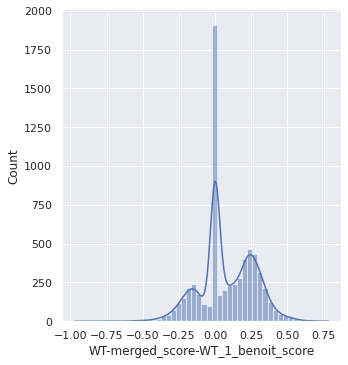

In [66]:
## Difference between benoit scores and mine

a=scores_wt["value"].values # wt_merged Leila data 
b=scores_wt_1["value"].values[0:len(a)] # benoit
g=sns.displot(a-b,bins=50,kde=True);
plt.xlabel("WT-merged_score-WT_1_benoit_score")
sns.set(font_scale=1)


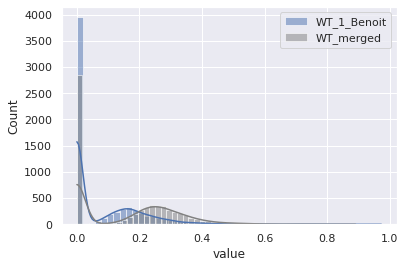

In [67]:
sns.histplot(scores_wt_1.loc[:,"value"],bins=50,kde=True,label="WT_1_Benoit");
sns.histplot(scores_wt.loc[:,"value"],bins=50,kde=True,color="gray",label="WT_merged");
plt.legend()

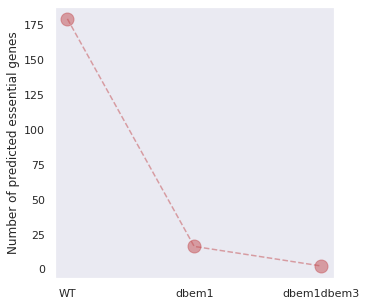

In [68]:
## Plot of how essential genes vary across backgrounds
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
values=[len(predicted_essentials_wt),len(predicted_essentials_bem1),
len(predicted_essentials_bem1_bem3)]

labels=["WT","dbem1","dbem1dbem3"]

plt.plot(labels,values,"ro--",alpha=0.5,markersize=13)
plt.ylabel("Number of predicted essential genes")
plt.grid()

#fig.savefig("../figures/fig_number_of_essential_genes_varying_backgrounds.png",dpi=300)

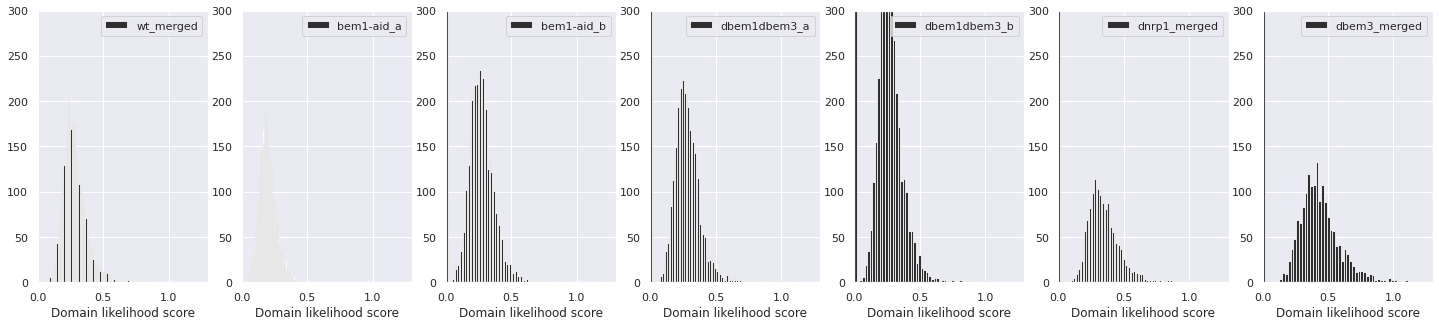

In [69]:
## Distributions of the scores per backgrounds

fig, ax = plt.subplots(nrows=1, ncols=len(backgrounds), figsize=(25, 5))
cm = plt.cm.get_cmap('RdYlBu_r')
#color=cm(i/len(backgrounds))
for i in np.arange(0,len(backgrounds)):
    
    ax[i].hist(scores_all_pd.loc[backgrounds[i]]["value"], bins=100, alpha=0.8, label=backgrounds[i], color="black")
    # plt.legend(loc='upper right')
    ax[i].set_xlim([0,1.3])
    ax[i].set_ylim([0,300])
    ax[i].set_xlabel('Domain likelihood score')


    ax[i].legend(loc='upper right')

#fig.savefig("../figures/fig_histogram_domain_likelihood_score_per_background.png",dpi=300)

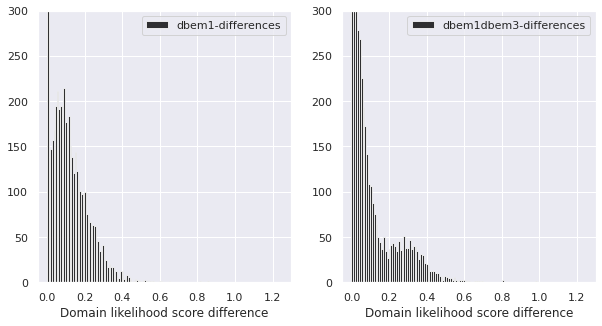

In [70]:
## Differences in score between replicates histogram
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
cm = plt.cm.get_cmap('RdYlBu_r')
#color=cm(i/len(backgrounds))
tmp=np.abs(scores_all_pd.loc["bem1-aid_a"]["value"]-scores_all_pd.loc["bem1-aid_b"]["value"])
ax[0].hist(tmp, bins=100, alpha=0.8, label="dbem1-differences", color="black")
# plt.legend(loc='upper right')
ax[0].set_xlim([-0.05,1.3])
ax[0].set_ylim([0,300])
ax[0].set_xlabel('Domain likelihood score difference')
ax[0].legend(loc='upper right')

tmp=np.abs(scores_all_pd.loc["dbem1dbem3_a"]["value"]-scores_all_pd.loc["dbem1dbem3_b"]["value"])
ax[1].hist(tmp, bins=100, alpha=0.8, label="dbem1dbem3-differences", color="black")
# plt.legend(loc='upper right')
ax[1].set_xlim([-0.05,1.3])
ax[1].set_ylim([0,300])
ax[1].set_xlabel('Domain likelihood score difference')
ax[1].legend(loc='upper right')
    
#fig.savefig("../figures/fig_histogram_domain_likelihood_score_differences_between_backgrounds.png",dpi=300)

In [72]:
## Differences in score between replicates scatter

# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# ax[0].scatter(scores_all_pd.loc["bem1-aid_a"]["value"][0:6239],scores_all_pd.loc["bem1-aid_b"]["value"],color="black",alpha=0.5,label="dbem1-replicates")
# ax[1].scatter(scores_all_pd.loc["dbem1dbem3_a"]["value"][0:6220],scores_all_pd.loc["dbem1dbem3_b"]["value"],color="black",alpha=0.5,label="dbem1dbem3-replicates")

# ax[0].set_xlim([0,1.3])
# ax[0].set_ylim([0,1.3])
# ax[0].set_xlabel('dbem1_a scores')
# ax[0].set_ylabel('dbem1_b scores')

# ax[1].set_xlim([0,1.3])
# ax[1].set_ylim([0,1.3])
# ax[1].set_xlabel('dbem1dbem3_a scores')
# ax[1].set_ylabel('dbem1dbem3_b scores')

#fig.savefig("../figures/fig_scatter_domain_likelihood_score_differences_between_backgrounds.png",dpi=300)

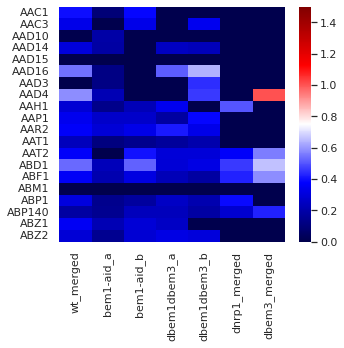

In [73]:
## heatmap variation of scores with backgrounds
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

n=20
sns.heatmap(matrix_differential_score[0:n,:], xticklabels=backgrounds,
yticklabels=all_genes_array_unique[0:n], cmap="seismic", vmin=0, vmax=1.5)
plt.tight_layout()
#fig.savefig("../figures/fig_prototype_heatmap_domain_likelihood_score_per_background.png",dpi=300)

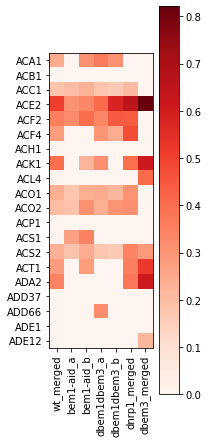

In [ ]:
## heatmap variation of scores with backgrounds with imshow
n=20
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 10))
plt.imshow(matrix_differential_score[n:2*n,:], interpolation='nearest', cmap=plt.cm.Reds)
plt.xticks(range(len(backgrounds)), backgrounds,rotation=90);
plt.yticks(range(n),all_genes_array_unique[n:2*n]);

plt.colorbar();
plt.tight_layout();
# fig.savefig("../figures/fig_prototype_heatmap_domain_likelihood_score_per_background_100_200.png",dpi=300)

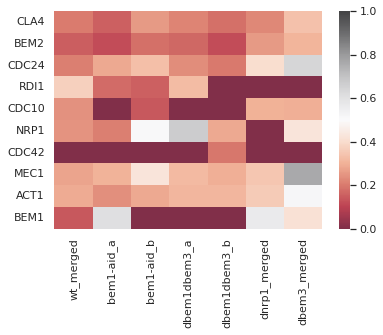

In [74]:
#fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

goi=["CLA4","BEM2","CDC24","RDI1","CDC10","NRP1","CDC42","MEC1","ACT1","BEM1"]
tmp=[]
for i in goi:
    tmp.append(np.where(all_genes_array_unique==i)[0][0])

goi_matrix=matrix_differential_score[tmp,:]
sns.heatmap(goi_matrix, xticklabels=backgrounds, yticklabels=goi, 
cmap="RdGy", vmin=0, vmax=1,alpha=0.8,annot_kws={"fontsize":4})
sns.set(font_scale=1) # font size 2

#g.savefig("../figures/fig_heatmap_domain_likelihood_score_per_background_goi.png",dpi=300)


Text(0.5, 1.0, 'Essentials genes')

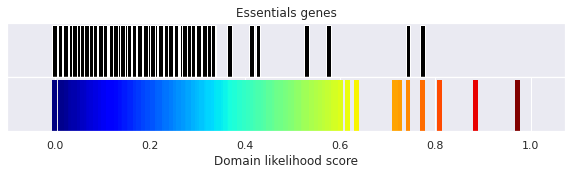

In [75]:
## Plot the essential genes vs scores on top of each other bar plot

fig,ax=plt.subplots(nrows=2,ncols=1,figsize=(10,2))

plt.subplots_adjust(hspace=0.01)

import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable

#data=scores_wt
data=scores_wt_1
N=len(data)

#N=1000
# Create fake data
X = np.linspace(0,N,N)
Y = data.loc[:,"value"][0:N]

# Pick a cmap
cmap = cm.get_cmap('jet')

i=0
data_colors=[]
for x0,x1 in zip(Y,Y[1:]):
    
    c = cmap((x0-Y.min())/Y.max())
    #print(x0,Y.min(),Y.max(),c)
    data_colors.append(c)
    ax[1].bar([x0,],0.5,0.01,
            color=c,
            linewidth=0)

    ax[0].bar([x0,],data.loc[:,"true essential"][i],0.01,color="black")
    
    i+=1

# sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(0,max(data_colors)[-1]))
# sm.set_array([])
# cbar = plt.colorbar(sm)
# cbar.set_label('Score', rotation=270,labelpad=25)

ax[1].set_xlim(Y.min()-0.1,Y.max()+0.1)
ax[0].set_xlim(Y.min()-0.1,Y.max()+0.1)
#ax[1].set_xticklabels(labels=np.round(X))
ax[1].set_yticks([])
ax[0].set_yticks([])
ax[0].set_xticks([])
ax[1].set_xlabel("Domain likelihood score")
ax[0].set_title("Essentials genes")




In [76]:
plt.tight_layout()
fig.savefig("../figures/fig_benoit_wt_1_heatmap_domain_likelihood_score_per_background_with_essentials.png",
dpi=300,bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

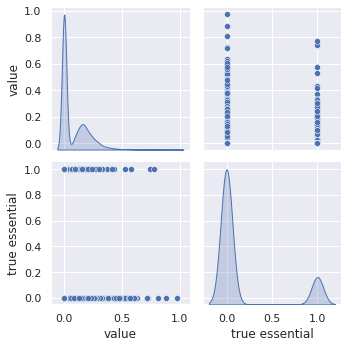

In [77]:
## Pairplot of essentials vs scores
data=scores_wt_1

fig=sns.pairplot(data,palette="Set1",diag_kind="kde",diag_kws={"shade":True})

sns.set(font_scale=1) # font size 2
plt.tight_layout()
#fig.savefig("../figures/fig_pairplot_score_with_essentials.png",dpi=300)
